# Implementation of Variational AutoEncoder (VAE)


In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torchvision.utils import save_image

In [4]:
# Model Hyperparameters

dataset_path = '~/datasets'



batch_size = 50

x_dim  = 784
hidden_dim = 400
latent_dim = 20

lr = 1e-3

epochs = 10

###    Step 1. Load (or download) Dataset

In [5]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=True,  **kwargs)

Extracting /Users/jean-baptistezhang/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /Users/jean-baptistezhang/datasets/MNIST/raw


Extracting /Users/jean-baptistezhang/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/jean-baptistezhang/datasets/MNIST/raw


Extracting /Users/jean-baptistezhang/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/jean-baptistezhang/datasets/MNIST/raw


Extracting /Users/jean-baptistezhang/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/jean-baptistezhang/datasets/MNIST/raw
Processing...
Done!


/Users/jean-baptistezhang/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Step 2. Define our model: Variational AutoEncoder (VAE)

In [10]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear(hidden_dim, latent_dim)
        self.training = True
        
    def forward(self, x):
        h_       = torch.relu(self.FC_input(x))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q")
        var      = torch.exp(0.5*log_var)              # takes exponential function
        z        = self.reparameterization(mean, var)
        
        return z, mean, log_var
    
    
    def reparameterization(self, mean, var,):
        epsilon = torch.rand_like(var)       # sampling epsilon which is a normal gaussian
        
        z = mean + var*epsilon                          # reparameterization trick
        
        return z

In [11]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h     = torch.relu(self.FC_hidden(x))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [12]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
                
    def forward(self, x):
        z, mean, log_var = self.Encoder(x)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [13]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [14]:
from torch.optim import Adam
 
BCE_loss = nn.BCELoss() # Binary Cross Entropy 

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [16]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  122.21542923953555
	Epoch 2 complete! 	Average Loss:  95.55008855035446
	Epoch 3 complete! 	Average Loss:  91.71047180023066
	Epoch 4 complete! 	Average Loss:  89.72828560339997
	Epoch 5 complete! 	Average Loss:  88.5243949222008
	Epoch 6 complete! 	Average Loss:  87.77440807199359
	Epoch 7 complete! 	Average Loss:  87.19561748234206
	Epoch 8 complete! 	Average Loss:  86.75186734795273
	Epoch 9 complete! 	Average Loss:  86.40641017579755
	Epoch 10 complete! 	Average Loss:  86.09149680804968
Finish!!


### Step 5. Evaluate the model

In [22]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

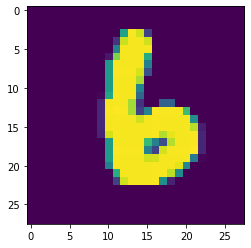

In [23]:
show_image(x, idx=2)

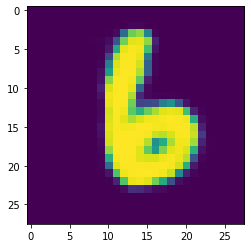

In [24]:
show_image(x_hat, idx=2)

### Step 6. Generate image from noise vector

In [31]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim)
    generated_images = decoder(noise)

In [16]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

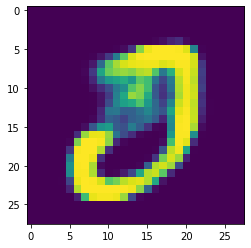

In [32]:
show_image(generated_images, idx=1)